In [ ]:
# set gpu allocation size 

In [151]:
import os
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import datetime
import matplotlib.pyplot as plt

Fd='/glade/derecho/scratch/yizhu/comp576/ORIENT'
os.chdir(Fd)
os.listdir()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'
print(device)
# GPU info
!nvidia-smi

cpu


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# model

In [152]:
with tf.device(device):
    input_dim = 964
    nnode1=412
    nnode2=105
    nnode3=116
    nnode4=128
    nnode5=1
    drop_rate1=0.36
    drop_rate2=0.09
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(nnode1, input_dim=input_dim, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(drop_rate1),
        tf.keras.layers.Dense(nnode2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(drop_rate2),
        tf.keras.layers.Dense(nnode3, activation='relu'),
        tf.keras.layers.Dense(nnode4, activation='relu'),
        tf.keras.layers.Dense(nnode5, activation='linear')
    ])
    
    # define loss function and optimizer with tf
    lr=0.01
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # compiler the model
    model.compile(optimizer=optimizer, loss=loss_object, metrics=['mse'])

model.summary()

Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_950 (Dense)           (None, 412)               397580    
                                                                 
 batch_normalization_385 (B  (None, 412)               1648      
 atchNormalization)                                              
                                                                 
 dropout_384 (Dropout)       (None, 412)               0         
                                                                 
 dense_951 (Dense)           (None, 105)               43365     
                                                                 
 batch_normalization_386 (B  (None, 105)               420       
 atchNormalization)                                              
                                                                 
 dropout_385 (Dropout)       (None, 105)            

# train and test model 

## make loader

In [157]:
# load
with open('ch11_data3.pkl','rb') as f:
  data=pickle.load(f)

In [159]:
# input and target
input=data.iloc[:,2:-2]
target=data.iloc[:,-2]

In [160]:
# 80% train, 20% test
x_train,x_test,y_train,y_test=train_test_split(input,target,test_size=0.2,shuffle=True)

In [161]:
# make cross validation that is 0.2 of the train data
kf = KFold(n_splits=5)

In [162]:
# print the shape of the data
print('x_train shape:',x_train.shape)
print('x_test shape:',x_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

x_train shape: (7884, 964)
x_test shape: (1972, 964)
y_train shape: (7884,)
y_test shape: (1972,)


## train and test

In [163]:
# fit the model
fold=0
batch_size=x_train[::100].shape[0]//10
# buffer_size=1000 if x_train[::100].shape[0]>10000 else 10000
nepo=15
all_history = []  # list to store history for each fold
for train_idx, val_idx in kf.split(x_train[::100]):
    fold+=1
    print('fold: ',fold)
    train_ds=tf.data.Dataset.from_tensor_slices((x_train[::100].iloc[train_idx,:],y_train[::100].iloc[train_idx]))
    val_ds=tf.data.Dataset.from_tensor_slices((x_train[::100].iloc[val_idx,:],y_train[::100].iloc[val_idx]))
    train_ds=train_ds.batch(batch_size)
    val_ds=val_ds.batch(batch_size)
    history=model.fit(train_ds,epochs=nepo,validation_data=val_ds)
    all_history.append(history.history)  # append history for current fold

# calculate average history
avg_history = {}
for key in all_history[0].keys():
    avg_history[key] = np.mean([fold_history[key] for fold_history in all_history], axis=0)


fold:  1
Epoch 1/15


9/9 [==============================] - 2s 27ms/step - loss: 2.2076 - mae: 1.1296 - val_loss: 0.6669 - val_mae: 0.6207
Epoch 2/15
9/9 [==============================] - 0s 6ms/step - loss: 1.2017 - mae: 0.8089 - val_loss: 1.8917 - val_mae: 1.1326
Epoch 3/15
9/9 [==============================] - 0s 6ms/step - loss: 0.7074 - mae: 0.6404 - val_loss: 2.9007 - val_mae: 1.2710
Epoch 4/15
9/9 [==============================] - 0s 7ms/step - loss: 0.3905 - mae: 0.4819 - val_loss: 1.5117 - val_mae: 0.9138
Epoch 5/15
9/9 [==============================] - 0s 6ms/step - loss: 0.2736 - mae: 0.3815 - val_loss: 1.3772 - val_mae: 0.7817
Epoch 6/15
9/9 [==============================] - 0s 7ms/step - loss: 0.1586 - mae: 0.3112 - val_loss: 1.0483 - val_mae: 0.8240
Epoch 7/15
9/9 [==============================] - 0s 7ms/step - loss: 0.1647 - mae: 0.3054 - val_loss: 1.4181 - val_mae: 0.9750
Epoch 8/15
9/9 [==============================] - 0s 7ms/step - loss: 0.1219 - mae: 0.2721 - val_loss: 1.3179 - va

Text(0, 0.5, 'MSE loss')

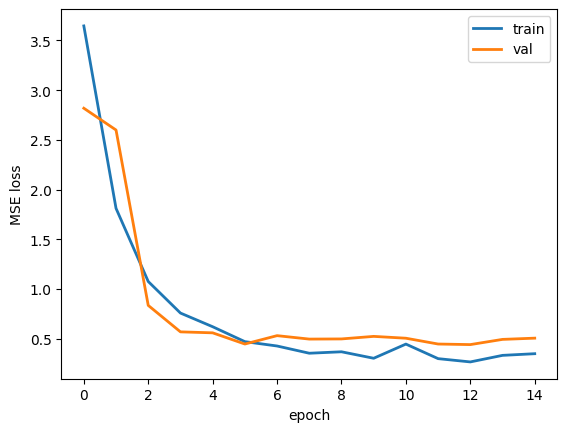

In [176]:
# plot history
plt.plot(avg_history['loss']*5,label='train',linewidth=2)
plt.plot(avg_history['val_loss'],label='val', linewidth=2)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [9]:
# predict and plot
y_pred=model.predict(x_test)
# plt.figure(figsize=(20,5))
# plt.plot(range(len(y_test)),y_test,label='target')
# plt.plot(range(len(y_test)),y_pred,label='prediction')
# plt.legend()
# plt.xlabel('date')
# plt.ylabel('flux')
y_pred=y_pred.reshape(-1)

6160/6160 [==============================] - 10s 2ms/step


In [29]:
import pandas as pd

# smooth the prediction and target
y_pred_s = pd.Series(y_pred).rolling(window=5, center=True).mean().values
y_test_s = pd.Series(y_test).rolling(window=5, center=True).mean().values

In [ ]:
# MAPE score
idx=y_test_s!=0
print(np.nanmean(np.abs((y_test_s[idx] - y_pred_s[idx]) / y_test_s[idx])) * 100)
# MAP score
idx=y_test_s!=0
print(np.nanmean(np.abs((y_test_s[idx] - y_pred_s[idx]))))

9.395490269814244
0.24095825037781057


# test the model on storm event

36/36 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'prediction on storm data')

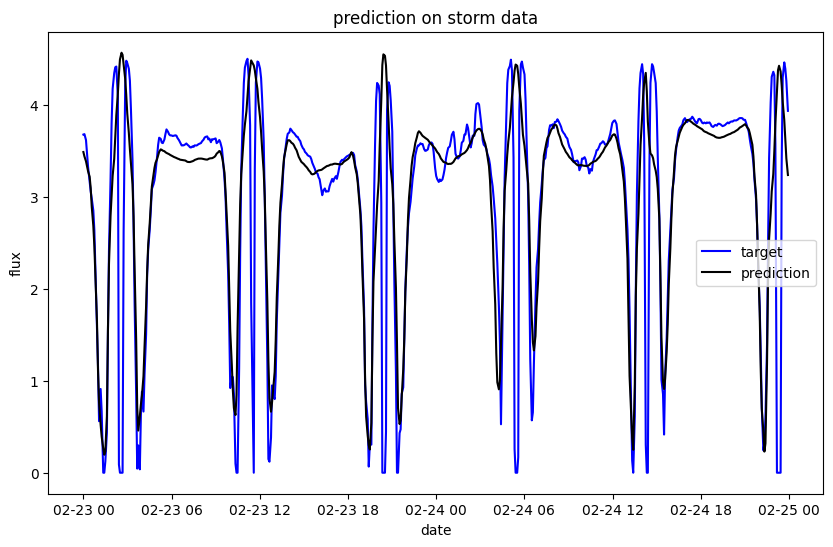

In [156]:
# predict on data between datetime(2017,3,25) datetime(2017,3,1,0)
stormdata=pickle.load(open('ch11_data2.pkl','rb'))

# make ds
x_storm=stormdata.iloc[:,2:-2]
y_storm=stormdata.iloc[:,-2]

# predict
y_storm_pred=model.predict(x_storm)

# plot
plt.figure(figsize=(10,6))
plt.plot(stormdata['date'][:len(stormdata['date'])//2], y_storm[:len(stormdata['date'])//2], label='target', color='blue')
plt.plot(stormdata['date'][:len(stormdata['date'])//2], y_storm_pred[:len(stormdata['date'])//2], label='prediction', color='black')
plt.legend()
plt.xlabel('date')
plt.ylabel('flux')
plt.title('prediction on storm data')
# plt.plot(y_storm_pred,label='prediction')
plt.legend()
plt.xlabel('date')
plt.ylabel('flux')
plt.title('prediction on storm data')